In [210]:
import numpy as np
import matplotlib.pyplot as plt

In [211]:
def deterministic_model_onstage(t, u0, s0, alfa, beta, gamma):
  #analytical solution of the deterministic model in the on stage
  u =  u0*np.exp(-beta*t) + (alfa/beta) * (1-np.exp(-beta*t))
  s =  s0*np.exp(-gamma*t) + (alfa/gamma) * (1-np.exp(-gamma*t)) + ((alfa-beta*u0)/(gamma-beta))*(np.exp(-gamma*t)-np.exp(-beta*t))
  return u, s

In [212]:
def deterministic_model_offstage(t, t_switch, u_switch, s_switch, beta, gamma):
  #analytical solution of the deterministic model in the pff stage
  u =  u_switch*np.exp(-beta*(t-t_switch))
  s =  s_switch*np.exp(-gamma*(t-t_switch)) - ((beta * u_switch/(gamma-beta))) * (np.exp(-gamma*(t-t_switch))-np.exp(-beta*(t-t_switch)))
  return u, s

In [213]:
def stochastic_model_onstage(t, alfa, beta, gamma):
  #analytical solution of the stochastic model in the on stage
  #in the on stage of the stochastic model, u and s are poisson distributed 
  #with parameter a and b respectively

  #distribution parameters
  a = (alfa/beta) * (1-np.exp(-beta*t))
  b = (alfa/gamma)*(1-np.exp(-gamma*t))+(alfa/(gamma-beta))*(np.exp(-gamma*t)-np.exp(-beta*t))

  #distributions
  P_u = np.random.poisson(a)
  P_s = np.random.poisson(b)
  return P_u, P_s

In [214]:
def stochastic_model_onstage_u0s0(t, u0, s0, alfa, beta, gamma):
  #analytical solution of the stochastic model in the on stage
  #in the on stage of the stochastic model, u and s are poisson distributed 
  #with parameter a and b respectively

  #distribution parameters
  a =  u0*np.exp(-beta*t) + (alfa/beta) * (1-np.exp(-beta*t))
  b =  s0*np.exp(-gamma*t) + (alfa/gamma) * (1-np.exp(-gamma*t)) + ((alfa-beta*u0)/(gamma-beta))*(np.exp(-gamma*t)-np.exp(-beta*t))

  #distributions
  P_u = np.random.poisson(a)
  P_s = np.random.poisson(b)
  return P_u, P_s

In [215]:
def stochastic_model_offstage(t, t_switch, u_switch, s_switch, beta, gamma):
  #analytical solution of the stochastic model in the off stage
  #in the off stage of the stochastic model u is binomial distributed, whereas s is 
  #a sum of 2 binomial distributions
  
  #success probabilities
  p1 = np.exp(-beta*(t-t_switch))
  p2 = (beta/(beta-gamma))*((np.exp(-gamma*(t-t_switch))-np.exp(-beta*(t-t_switch)))/(1-np.exp(-beta*(t-t_switch)))) #correct if beta != gamma
  p3 = np.exp(-gamma*(t-t_switch))
  
  #distributions
  B_u = np.random.binomial(np.round(u_switch).astype(int), p1)
  B_k = np.random.binomial(np.round(u_switch*(1-p1)).astype(int), p2)
  B_n_k = np.random.binomial(np.round(s_switch).astype(int), p3)
  B_s = B_k + B_n_k

  return B_u, B_s

In [216]:
def simulation(u0, s0, alfa, beta, gamma, t_final, n_simulated_data, relative_t_switch):
  
  #define the switch time
  step = t_final / n_simulated_data
  t_switch_index = np.round(relative_t_switch * n_simulated_data).astype(int)
  t_switch = np.round(step * t_switch_index).astype(int)
  
  #define linearly spaced time points for on and off stage
  t_range_on = np.linspace(0.01, t_switch, n_simulated_data)
  t_range_off = np.linspace(t_switch+0.001, t_final, n_simulated_data)

  #run deterministic and stochastic models
  u_det_on, s_det_on = deterministic_model_onstage(t_range_on, u0, s0, alfa, beta, gamma)
  u_stoch_on, s_stoch_on = stochastic_model_onstage_u0s0(t_range_on, u0, s0, alfa, beta, gamma)

  #grep the last u and s values at the end of the on stage
  u_switch = u_det_on[-1]
  s_switch = s_det_on[-1]
  u_det_off, s_det_off = deterministic_model_offstage(t_range_off, t_switch, u_switch, s_switch, beta, gamma)
  u_stoch_off, s_stoch_off = stochastic_model_offstage(t_range_off, t_switch, u_switch, s_switch, beta, gamma)

  #concatenate time and u,s values from on stage and off stage
  t = np.concatenate((t_range_on, t_range_off))
  u_det = np.concatenate((u_det_on, u_det_off))
  s_det = np.concatenate((s_det_on, s_det_off))
  u_stoch = np.concatenate((u_stoch_on, u_stoch_off))
  s_stoch = np.concatenate((s_stoch_on, s_stoch_off))

  return t, t_switch, u_det, s_det, u_stoch, s_stoch

In [217]:
def plot_simulation(t, t_switch, u_det, s_det, u_stoch, s_stoch):
  #plot u,s as a function of t
  plt.figure(figsize=(12,6))
  plt.plot(t, u_det, label='unspliced deterministic')
  plt.plot(t, s_det, label='spliced deterministic')
  plt.scatter(t, u_stoch, s=5, label='unspliced stochastic')
  plt.scatter(t, s_stoch, s=5, label='spliced stochastic')
  plt.axvline(x = t_switch, color='green', linestyle='--', label = 'switch time')
  plt.legend()
  plt.grid(True)
  plt.title("Analytical solutions to deterministic and stochastic model")


In [218]:
def plot_phase_plane(t, t_switch, u0, s0, n_simulated_data, u_det, s_det, u_stoch, s_stoch):
  #plot s as a function of u
  plt.figure(figsize=(12,6))
  u_det_on = u_det[:n_simulated_data]
  s_det_on = s_det[:n_simulated_data]
  u_det_off = u_det[n_simulated_data:]
  s_det_off = s_det[n_simulated_data:]
  u_stoch_on = u_stoch[:n_simulated_data]
  s_stoch_on = s_stoch[:n_simulated_data]
  u_stoch_off = u_stoch[n_simulated_data:]
  s_stoch_off = s_stoch[n_simulated_data:]

  plt.plot(u_det_on, s_det_on, label='on stage deterministic')
  plt.plot(u_det_off, s_det_off, label='off stage deterministic')
  plt.scatter(u_stoch_on, s_stoch_on, s=5, label='on stage stochastic')
  plt.scatter(u_stoch_off, s_stoch_off, s=5, label='off stage stochastic')
  plt.scatter(u_det_on[-1], s_det_on[-1], s=80)
  plt.scatter(u_det_on[0], s_det_on[0], s=80)
  plt.scatter(u_det_off[-1], s_det_off[-1], s=80)

  plt.text(u_det_on[-1]+0.5, s_det_on[-1]-0.1, f'switch time:{t_switch}')
  plt.text(u_det_on[0]+0.5, s_det_on[0]-1, f'start: (u0, s0) = ({u0},{s0})')
  plt.text(u_det_off[-1]+0.5, s_det_off[-1]-1, f'end: (u, s) = ({np.round(u_det_off[-1], -1)},{np.round(s_det_off[-1], -1)})')

  plt.legend()
  plt.grid(True)
  plt.title("Phase plane")

In [219]:
def main(
  u0 = 3,
  s0 = 4,
  alfa = 20,
  beta = 1,
  gamma = 0.75,
  t_final = 2,
  n_simulated_data = 200,
  relative_t_switch = 0.5,
  periodic_alfa = False): #from 0 to 1

  t, t_switch, u_det, s_det, u_stoch, s_stoch = simulation(u0, s0, alfa, beta, gamma, 
                                                           t_final, n_simulated_data, 
                                                           relative_t_switch)

  plot_simulation(t, t_switch, u_det, s_det, u_stoch, s_stoch)
  plot_phase_plane(t, t_switch, u0, s0, n_simulated_data, u_det, s_det, u_stoch, s_stoch)
  

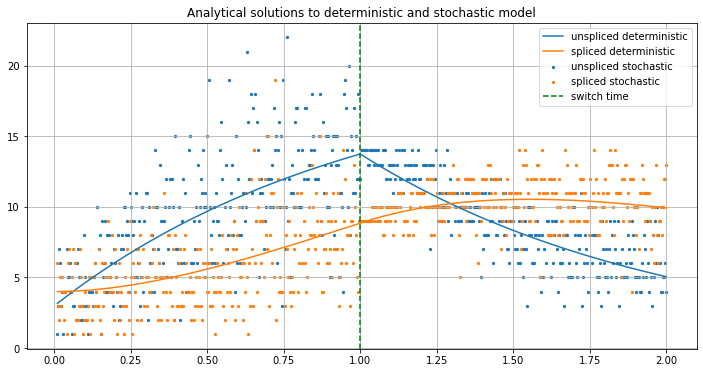

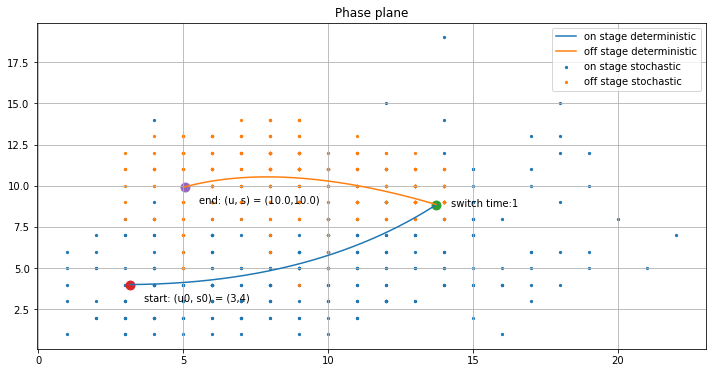

In [220]:
main()